# Exponential decay profile

Simulates an exponential decay density profile to check group delay behaviour

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
from refo import *
from scipy import signal
from scipy.interpolate import CubicSpline
#
from matplotlib import rc
plt.style.use('helvet')
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{tgheros}',    # helvetica font
    r'\usepackage{sansmath}',   # math-font matching  helvetica
    r'\sansmath'                # actually tell tex to use it!
    r'\usepackage{siunitx}',    # micro symbols
    r'\sisetup{detect-all}',    # force siunitx to use the fonts
]
#

In [2]:
def phase_shift(rad, dens, fpro, Rant=2.32, interpts=8192):
    interp_perf = interp1d(rad, dens)
    interp_rad = interp1d(dens, rad)
    total_phase = []

    #Avoid numerical errors due to the sqrt
    epsi = 1e-15

    #Do a numeric aproach 
    for f in fpro:
        dens_probe = f2n(f)
        r_int = np.linspace(interp_rad(dens_probe)+epsi, Rant, interpts, endpoint=True)
        n_int = interp_perf(r_int)
        #Refractive index
        NO = np.sqrt(1-n_int/dens_probe)
        NO[0] = 0.0
        
        #Refractive index
        total_phase.append( 4.0*np.pi*f/2.998e8*simps(NO, x=r_int)-np.pi/2 )
    
    return np.array(total_phase)

## Simulate a typical AUG L-mode density profile

In [10]:
def perf_sol(x, sep_dens, sep_center, widsol):
    return sep_dens*np.exp(-(x-sep_center)/widsol)

In [21]:
def dif_perf_sol(x, sep_dens, sep_center, widsol):
    return -sep_dens/widsol*np.exp(-(x-sep_center)/widsol)

In [26]:
dif_perf_sol(2.15, 0.8e19, 2.15, 0.02)

-4e+20

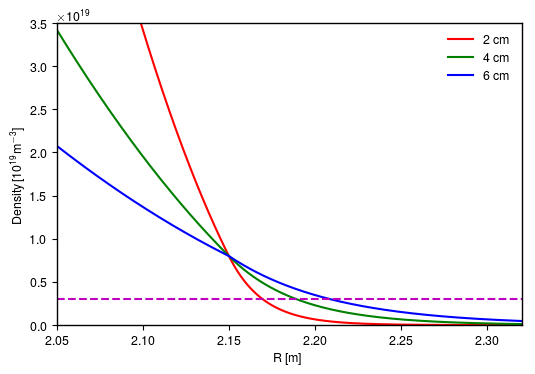

In [65]:
R0 = 2.05
Rsep = 2.15
Rsep_wid = 2.17
Rant = 2.32
npts = 1024
wid = 0.15
n0 = 6e19

radius = np.linspace(R0, Rant, npts, endpoint=True)
core_pts = radius<Rsep
sol_pts = radius >=Rsep
#Copy arrays
perf1 = np.zeros_like(radius)
perf2 = np.zeros_like(radius)
perf3 = np.zeros_like(radius)

sep_dens = 0.8e19 
sep_center = 2.15

def perf_core(x, sep_dens, Rsep, deriv, widsol):
    densi = sep_dens + 1e18*((Rsep-x)/widsol)**2 + deriv*(x-Rsep)
    return densi
    
widsol = 0.02
perf1[core_pts] = perf_core(radius[core_pts], sep_dens, Rsep, -4e20, widsol)
perf1[sol_pts] = perf_sol(radius[sol_pts], sep_dens, sep_center, widsol)

widsol = 0.04
perf2[core_pts] = perf_core(radius[core_pts], sep_dens, Rsep, -2e20, widsol)
perf2[sol_pts] = perf_sol(radius[sol_pts], sep_dens, sep_center, widsol)

widsol = 0.06
perf3[core_pts] = perf_core(radius[core_pts], sep_dens, Rsep, -1e20, widsol)
perf3[sol_pts] = perf_sol(radius[sol_pts], sep_dens, sep_center, widsol)

plt.figure(dpi=100)
#plt.plot(radius, dens, label='Core', color='k')
plt.plot(radius, perf1, label='2 cm')
plt.plot(radius, perf2, label='4 cm')
plt.plot(radius, perf3, label='6 cm')
plt.ylim(0, 3.5e19)
plt.xlim(2.05,Rant)
plt.legend(frameon=False)
plt.axhline(0.3e19, ls='--', color='m')
plt.xlabel('R [m]')
plt.ylabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.show()

In [93]:
fstart = 4e9
fstop = 30e9
dstart = f2n(fstart)
dstop = f2n(fstop)
npts = 1024
fprobe = np.linspace(fstart, fstop, npts, endpoint=True)

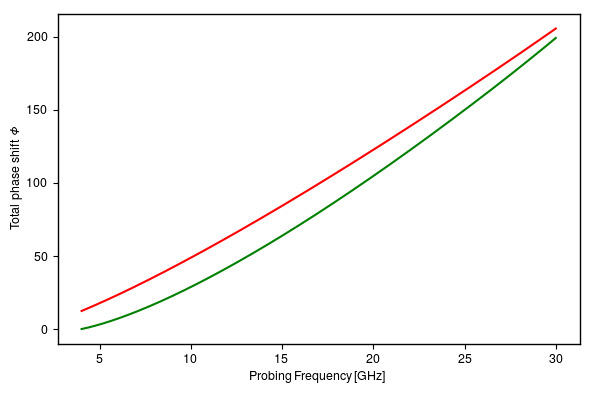

In [94]:
plt.figure(dpi=100)

psh1 = phase_shift(radius, perf1, fprobe)
psh2 = phase_shift(radius, perf2, fprobe)
#psh3 = phase_shift(radius, perf3, fprobe)

plt.plot(fprobe*1e-9, psh1)
plt.plot(fprobe*1e-9, psh2)
#plt.plot(fprobe*1e-9, psh3)

plt.xlabel('$\mathrm{Probing\,Frequency\,[GHz]}$')
plt.ylabel('Total phase shift $\Phi$')
plt.tight_layout()
plt.show() 

In [95]:
dphdf1 = 1/(2*np.pi) * np.gradient(psh1, fprobe)
dphdf2 = 1/(2*np.pi) * np.gradient(psh2, fprobe)
#dphdf3 = 1/(2*np.pi) * np.gradient(psh3, fprobe)

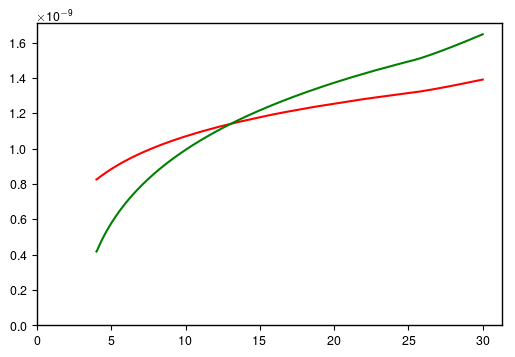

In [96]:
plt.figure(dpi=100)
plt.plot(fprobe*1e-9, dphdf1)
plt.plot(fprobe*1e-9, dphdf2)
#plt.plot(fprobe*1e-9, dphdf3)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  
/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


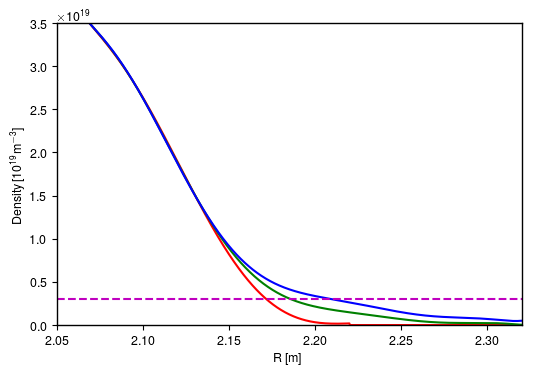

In [6]:
pol1 = np.poly1d(np.polyfit(radius, perf1*1e-19, 19))
pol2 = np.poly1d(np.polyfit(radius, perf2*1e-19, 19))
pol3 = np.poly1d(np.polyfit(radius, perf3*1e-19, 19))

sperf1 = pol1(radius)*1e19
#Additional fix
sperf1[radius>2.22] = 0.0

sperf2 = pol2(radius)*1e19
sperf3 = pol3(radius)*1e19

plt.figure(dpi=100)
plt.plot(radius, sperf1)
plt.plot(radius, sperf2)
plt.plot(radius, sperf3)
plt.ylim(0, 3.5e19)
plt.xlim(2.05,Rant)
plt.legend(frameon=False)
plt.axhline(0.3e19, ls='--', color='m')
plt.xlabel('R [m]')
plt.ylabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.show()

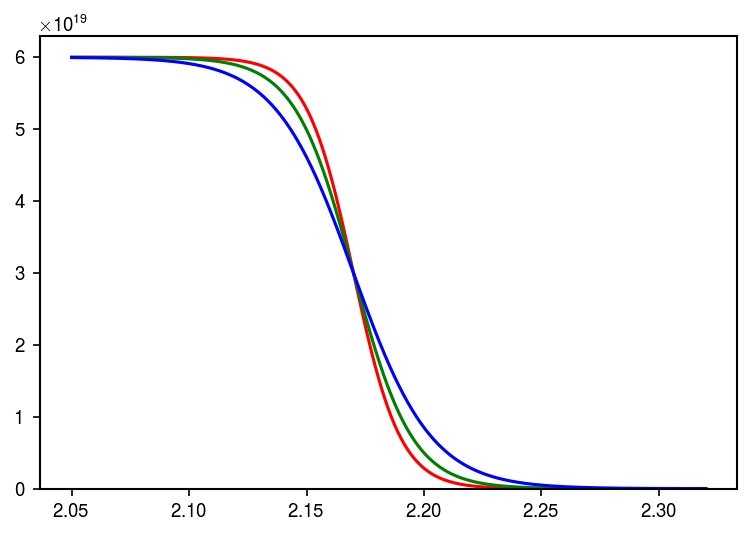

In [116]:
plt.figure(dpi=150)

#plt.plot(radius, np.arctanh((radius-2.17)/2.17))

perf1 = ((np.tanh(50*(2.17-radius))+1.0)/2.0)*n0
plt.plot(radius, perf1)

perf2 = ((np.tanh(40*(2.17-radius))+1.0)/2.0)*n0
plt.plot(radius, perf2)

perf3 = ((np.tanh(30*(2.17-radius))+1.0)/2.0)*n0
plt.plot(radius, perf3)

plt.ylim(bottom=0)
plt.show()

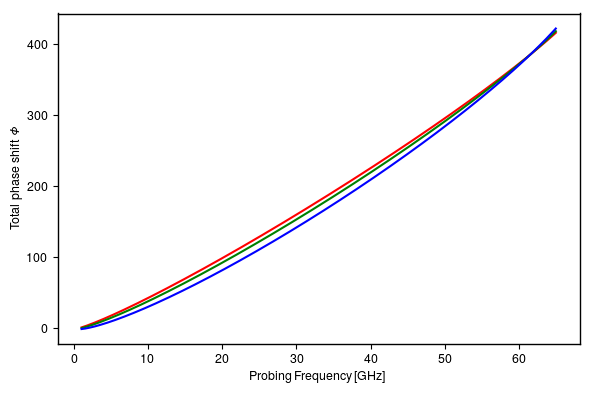

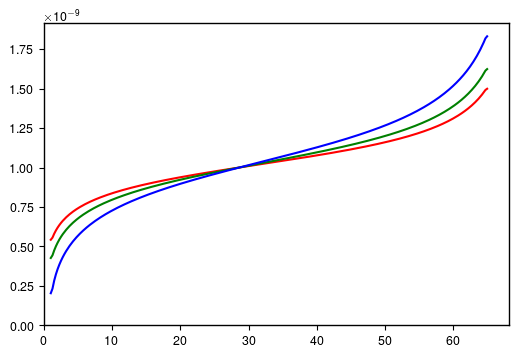

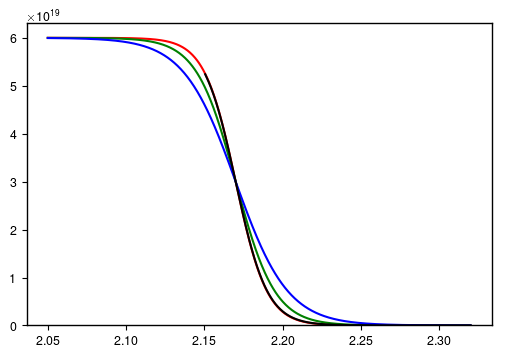

In [117]:
plt.figure(dpi=100)
r1, n1, fpro, gdel = CalcInvPerfO(fprobe, dphdf1, vacd=0.0)

plt.plot(radius, perf1)
plt.plot(radius, perf2)
plt.plot(radius, perf3)

plt.plot(Rant-r1, n1, color='k')

plt.ylim(bottom=0)
plt.show()

In [17]:
newpts = 300
fpp = np.linspace(fstart, fstop, newpts, endpoint=True)

int1 = interp1d(fprobe, psh1, kind='cubic')
pshn1 = int1(fpp)
#
int2 = interp1d(fprobe, psh2, kind='cubic')
pshn2 = int2(fpp)
#
int3 = interp1d(fprobe, psh3, kind='cubic')
pshn3 = int3(fpp)

In [18]:
dx = fpp[1]-fpp[0]
dphdf1 = 1/(2*np.pi) * np.diff(pshn1)/dx
dphdf2 = 1/(2*np.pi) * np.diff(pshn2)/dx
dphdf3 = 1/(2*np.pi) * np.diff(pshn3)/dx

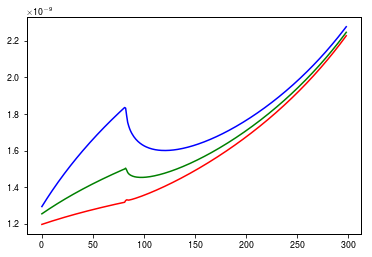

In [21]:
plt.plot(dphdf1)
plt.plot(dphdf2)
plt.plot(dphdf3)

/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  
/home/guimas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


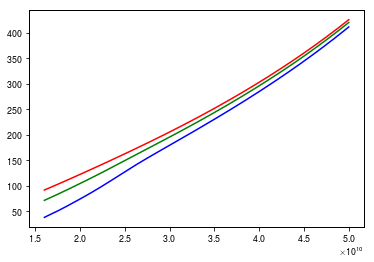

In [22]:
pol1 = np.poly1d(np.polyfit(fprobe*1e-9, psh1, 17))
pol2 = np.poly1d(np.polyfit(fprobe*1e-9, psh2, 17))
pol3 = np.poly1d(np.polyfit(fprobe*1e-9, psh3, 17))

plt.plot(fprobe, pol1(fprobe*1e-9))
plt.plot(fprobe, pol2(fprobe*1e-9))
plt.plot(fprobe, pol3(fprobe*1e-9))

In [9]:
dx = fprobe[2]-fprobe[1]

In [19]:
dphdf1.shape

(1023,)

In [12]:
dphdf1 = 1/(2*np.pi) * np.diff(psh1)/dx
dphdf2 = 1/(2*np.pi) * np.diff(psh2)/dx
dphdf3 = 1/(2*np.pi) * np.diff(psh3)/dx

In [38]:
dphdf1 = 1/(2*np.pi) * np.gradient(psh1, fprobe, edge_order=2)
dphdf2 = 1/(2*np.pi) * np.gradient(psh2, fprobe, edge_order=2)
dphdf3 = 1/(2*np.pi) * np.gradient(psh3, fprobe, edge_order=2)

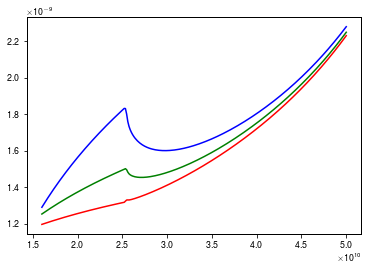

In [39]:
plt.plot(fprobe, dphdf1)
plt.plot(fprobe, dphdf2)
plt.plot(fprobe, dphdf3)

In [23]:
r1, n1, fpro, gdel = CalcInvPerfO(fprobe, dphdf1, vacd=0.0)
r2, n2, fpro, gdel = CalcInvPerfO(fprobe, dphdf2, vacd=0.0)
r3, n3, fpro, gdel = CalcInvPerfO(fprobe, dphdf3, vacd=0.0)


IndexError: index 288 is out of bounds for axis 0 with size 288

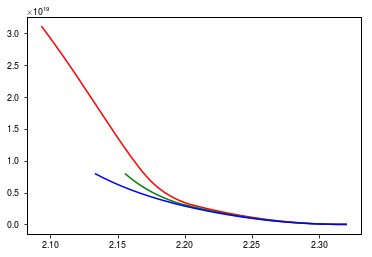

In [30]:
plt.plot(Rant-r1,n1)
plt.plot(Rant-r2,n2)
plt.plot(Rant-r3,n3)

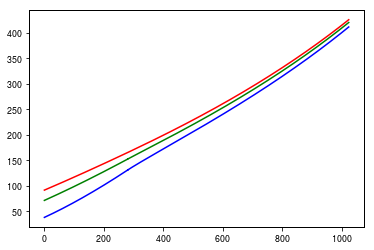

In [21]:
plt.plot(psh1)
plt.plot(psh2)
plt.plot(psh3)

In [69]:
fsamp = 40e6

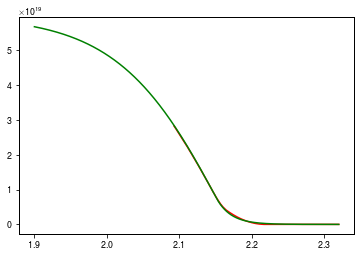

In [69]:
sig1 = np.cos(psh1)

f, t, Sxx = signal.spectrogram(sig1, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)
beat_f = f[np.argmax(Sxx, axis=0)]

Swp_rate = (fstop-fstart) / (1024.0/fsamp)
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

r1, n1, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-2.22)
plt.plot(Rant-r1,n1)
plt.plot(radtot, perf1)

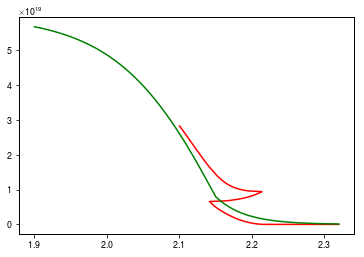

In [70]:
sig = np.cos(psh2)

f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)
beat_f = f[np.argmax(Sxx, axis=0)]

Swp_rate = (fstop-fstart) / (1024.0/fsamp)
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

r1, n1, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-2.22)
plt.plot(Rant-r1,n1)
plt.plot(radtot, perf2)

In [45]:
wavlen = 2.998e8/(fprobe)

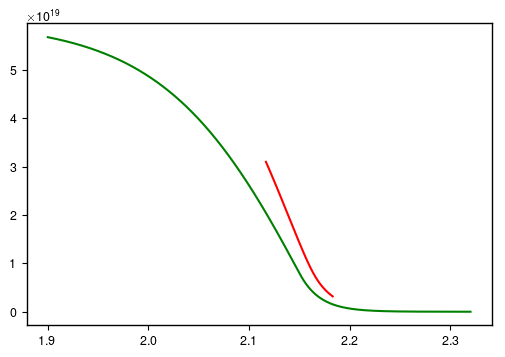

In [58]:
plt.figure(dpi=100)
plt.plot(Rant-wavlen*psh1/(4*np.pi), f2n(fprobe))
plt.plot(radtot, perf1)

In [44]:
2.998e8/10e9

0.02998

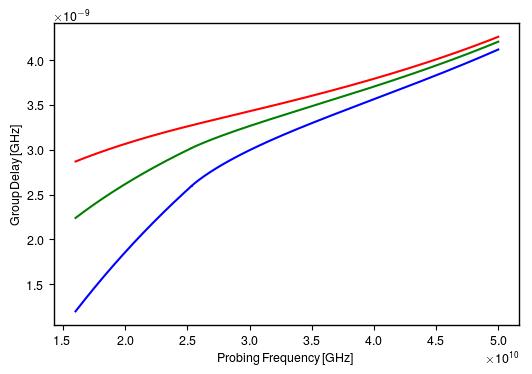

In [30]:
plt.figure(dpi=100)

tau1 = 1/(2.0*fprobe)*psh1
tau2 = 1/(2.0*fprobe)*psh2
tau3 = 1/(2.0*fprobe)*psh3

plt.plot(fprobe, tau1)
plt.plot(fprobe, tau2)
plt.plot(fprobe, tau3)

plt.xlabel('$\mathrm{Probing\,Frequency\,[GHz]}$')
plt.ylabel('$\mathrm{Group\,Delay\,[GHz]}$')
plt.show()

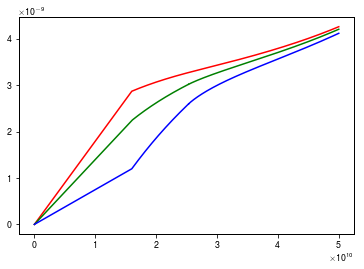

In [31]:
r1, n1, fpro, gdel = CalcInvPerfO(fprobe, tau1, vacd=0.0)
plt.plot(fpro, gdel)
r2, n2, fpro, gdel = CalcInvPerfO(fprobe, tau2, vacd=0.0)
plt.plot(fpro, gdel)
r3, n3, fpro, gdel = CalcInvPerfO(fprobe, tau3, vacd=0.0)
plt.plot(fpro, gdel)

plt.show()

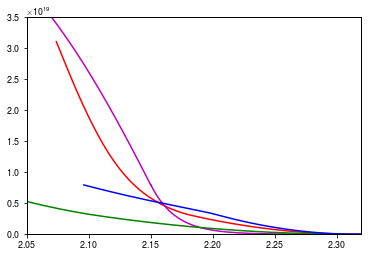

In [33]:
plt.plot(Rant-r1/2, n1)
plt.plot(radtot, perf1, color='m')
plt.plot(Rant-r2, n2)
plt.plot(Rant-r3, n3)
plt.xlim(2.05, Rant)
plt.ylim(0,3.5e19)
plt.show()

### Extracting the beat frequency

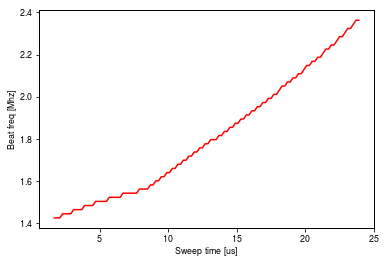

In [12]:
beat_f = f[np.argmax(Sxx, axis=0)]

plt.plot(t, beat_f)
#plt.ylim(0, 2.)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [Mhz]')
plt.show()

### Best-path?

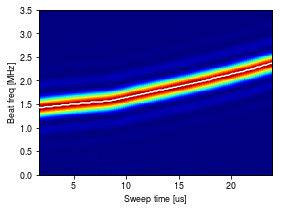

In [13]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

beat_f = f[np.argmax(Sxx, axis=0)]

plt.figure(figsize=(4,3.))

plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.plot(t, beat_f, zorder=10, color='w')
plt.ylim(0, 3.5)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.tight_layout()
plt.savefig('figures/Mapping_bp.png', dpi=300)
plt.show()

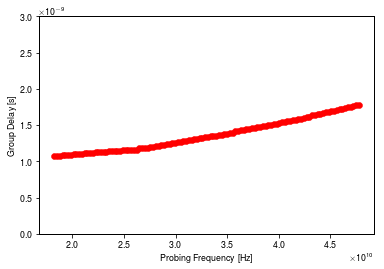

In [14]:
Swp_rate = (fstop-fstart) / (1024.0/fsamp)
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

plt.scatter(f_probsw, tau_g)
plt.ylim(0, 3e-9)
plt.xlabel('Probing Frequency [Hz]')
plt.ylabel('Group Delay [s]')
plt.show()

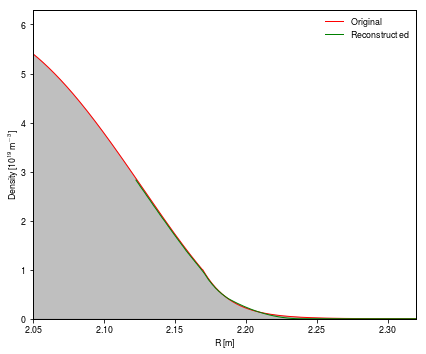

In [15]:
plt.figure(figsize=(6,5))
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()

Rinit = 2.24
r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens*1e-19, label='Original', lw=1)
R_reco = Rant-r
plt.plot(R_reco, n*1e-19, label='Reconstructed', lw=1)
plt.xlim(2.05, 2.32)
plt.legend(frameon=False)
plt.tight_layout()

#plt.savefig('figures/Reconstructed_profile.png', dpi=300)
plt.show()

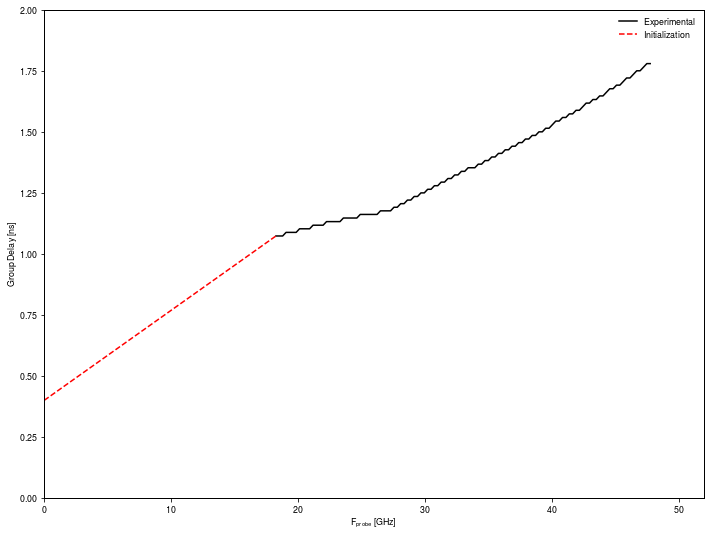

In [16]:
plt.figure(figsize=(10,7.5))

init_pts = 32
init_fpro = np.linspace(0.0, f_probsw[0], init_pts)
vac_gdel_example = (2.32-2.26)*2.0/2.998e8
init_tau = np.linspace(vac_gdel_example, tau_g[0], init_pts)

plt.plot(f_probsw*1e-9, tau_g*1e9, color='k', label='Experimental')
plt.plot(init_fpro*1e-9, init_tau*1e9, color='r', ls='--', label='Initialization')

plt.legend(frameon=False)
plt.ylim(0.0, 2.)
plt.xlim(0, 52)
plt.xlabel('$\mathrm{F_{probe}\,[GHz]}$')
plt.ylabel('$\mathrm{Group\,Delay\,[ns]}$')
plt.xticks([0,10,20,30,40,50])
plt.tight_layout()
#plt.savefig('figures/group_delay_final.png', dpi=300)
plt.show()

### Compute the differences between method and original data

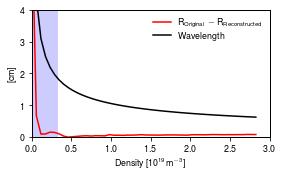

In [17]:
mindens = 0.001e19
maxdens = max(n)
densdiff = np.linspace(mindens, maxdens, endpoint=True)

interp_orig_data = interp1d(dens, radius)
interp_reco_data = interp1d(n, R_reco)
plt.figure(figsize=(4,2.5))
plt.axvspan(0,f2n(16e9)*1e-19, color='b', alpha=0.2)
plt.plot(densdiff*1e-19, np.abs(interp_orig_data(densdiff)-interp_reco_data(densdiff))*1e2,
         label='$\mathrm{R_{Original}-R_{Reconstructed}}$')
plt.plot(densdiff*1e-19, 2.998e8/(n2f(densdiff))*1e2, color='k', label='Wavelength')
plt.xlim(0,3)
plt.ylabel('$\mathrm{[cm]}$')
plt.xlabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.legend(frameon=False)
plt.ylim(0,4)
plt.tight_layout()
#plt.savefig('figures/uncertainty.png', dpi=300)

#### Excellent initialization

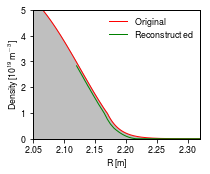

In [18]:
plt.figure(figsize=(3,2.5))
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(0,5)
plt.xlim(Rmid, Rant)
plt.tight_layout()

Rinit = 2.22
r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens*1e-19, label='Original', lw=1)
R_reco = Rant-r
plt.plot(R_reco, n*1e-19, label='Reconstructed', lw=1)
plt.xlim(2.05, 2.32)
plt.legend(frameon=False)
plt.tight_layout()

#plt.savefig('figures/excellent_reconstructed_profile.png', dpi=300)
plt.show()

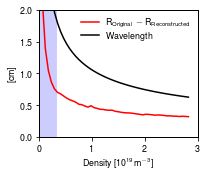

In [19]:
mindens = 0.001e19
maxdens = max(n)
densdiff = np.linspace(mindens, maxdens, endpoint=True)

interp_orig_data = interp1d(dens, radius)
interp_reco_data = interp1d(n, R_reco)

plt.figure(figsize=(3,2.5))
plt.axvspan(0,f2n(16e9)*1e-19, color='b', alpha=0.2)
plt.plot(densdiff*1e-19, np.abs(interp_orig_data(densdiff)-interp_reco_data(densdiff))*1e2,
         label='$\mathrm{R_{Original}-R_{Reconstructed}}$')
plt.plot(densdiff*1e-19, 2.998e8/(n2f(densdiff))*1e2, color='k', label='Wavelength')
plt.xlim(0,3)
plt.ylabel('$\mathrm{[cm]}$')
plt.xlabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.legend(frameon=False)
plt.ylim(0,2)
plt.tight_layout()
plt.savefig('figures/excellent_uncertainty.png', dpi=300)